### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Import Machine Learning Models and Tools

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### Import Model Evaluation and Validation Tools

In [3]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

### Load Datasets

In [4]:
# Load train and test datasets.
train = pd.read_csv("C:/Users/Rutvik/OneDrive/Desktop/CODESOFT INTERNSHIP TASK/CODESOFT_Task2_Credit_Card_Fraud_Detection/Credit Card Transactions Fraud Detection Dataset/fraudTrain.csv")
test = pd.read_csv("C:/Users/Rutvik/OneDrive/Desktop/CODESOFT INTERNSHIP TASK/CODESOFT_Task2_Credit_Card_Fraud_Detection/Credit Card Transactions Fraud Detection Dataset/fraudTest.csv")

### Display Data Information

In [5]:
# Show dataset shapes and preview train data.
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)
train.head()

Train Shape: (1296675, 23)
Test Shape: (555719, 23)


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


### Drop Unnecessary Column

In [6]:
# Drop unnecessary columns.
train.drop(columns=['Unnamed: 0'], inplace=True)
test.drop(columns=['Unnamed: 0'], inplace=True)

### Drop High-Cardinality Columns

In [7]:
# Drop high cardinality columns.
high_card_cols = ['trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 'city', 'state', 'zip', 'dob', 'unix_time', 'merch_lat', 'merch_long', 'merchant']
train.drop(columns=high_card_cols, inplace=True, errors='ignore')
test.drop(columns=high_card_cols, inplace=True, errors='ignore')

### Inspect Categorical Columns

In [8]:
# List categorical columns and unique values.
cat_cols = train.select_dtypes(include='object').columns

for col in cat_cols:
    print(f"{col}: {train[col].nunique()} unique values")

category: 14 unique values
gender: 2 unique values
job: 494 unique values
trans_num: 1296675 unique values


### Select Columns for One-Hot Encoding

In [9]:
# Select categorical columns with <100 unique values.
safe_encode_cols = [col for col in cat_cols if train[col].nunique() < 100]

### One-Hot Encode Categorical Columns

In [10]:
# Encode categorical columns using one-hot encoding.
train = pd.get_dummies(train, columns=safe_encode_cols, drop_first=True)
test = pd.get_dummies(test, columns=safe_encode_cols, drop_first=True)

### Prepare Training Data

In [11]:
# Split features and target variable for training set.
X_train = train.drop('is_fraud', axis=1)
y_train = train['is_fraud']

### Prepare Testing Data

In [12]:
# Split features and target variable for test set.
X_test = test.drop('is_fraud', axis=1)
y_test = test['is_fraud']

### Align Test Data with Training Data

In [13]:
# Ensure X_test has the same columns as X_train.
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

### Identify Non-Numeric Columns

In [14]:
# Check for non-numeric columns in the training set.
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols.tolist())

Non-numeric columns: ['job', 'trans_num']


### Drop Non-Numeric Columns

In [15]:
# Drop non-numeric columns from training and test sets.
X_train = X_train.drop(columns=non_numeric_cols)
X_test = X_test.drop(columns=non_numeric_cols)

### Scale Features

In [16]:
# Scale the features using StandardScaler.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.fit_transform(X_train)

### Model Training and Evaluation

##### Logistic Regression

In [17]:
# Train a logistic regression model with hyperparameter tuning.
log_params = {'C': [0.1, 1, 10]}
log_model = GridSearchCV(LogisticRegression(max_iter=1000), log_params, cv=5, scoring='accuracy')
log_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.1, 1, 10]}, scoring='accuracy')

In [18]:
# Get the best estimator and make predictions on the test set.
log_best = log_model.best_estimator_
y_pred_log = log_best.predict(X_test_scaled)

In [19]:
# Evaluate the model's performance.
print(" === Logistic Regression === ")
print("\nBest Logistic Regression Parameters:", log_model.best_params_)
print("\nLogistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))

 === Logistic Regression === 

Best Logistic Regression Parameters: {'C': 0.1}

Logistic Regression Accuracy: 0.9955589065696872

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.00      0.00      0.00      2145

    accuracy                           1.00    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      1.00      0.99    555719



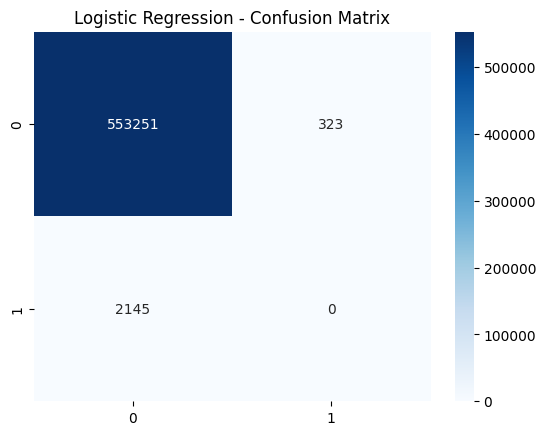

In [20]:
# Plot confusion matrix for logistic regression.
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

##### Decision Tree

In [21]:
# Train a decision tree model with hyperparameter tuning.
tree_params = {'max_depth': [10, 20], 'criterion': ['gini', 'entropy']}
tree_model = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5, scoring='accuracy')
tree_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20]},
             scoring='accuracy')

In [22]:
# Get the best estimator and make predictions on the test set.
tree_best = tree_model.best_estimator_
y_pred_tree = tree_best.predict(X_test_scaled)

In [23]:
# Evaluate the decision tree model's performance.
print(" === Decision Tree === ")
print("\nBest Decision Tree Parameters:", tree_model.best_params_)
print("\nDecision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tree))

 === Decision Tree === 

Best Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 10}

Decision Tree Accuracy: 0.9976049046370558

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.72      0.62      0.67      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.81      0.83    555719
weighted avg       1.00      1.00      1.00    555719



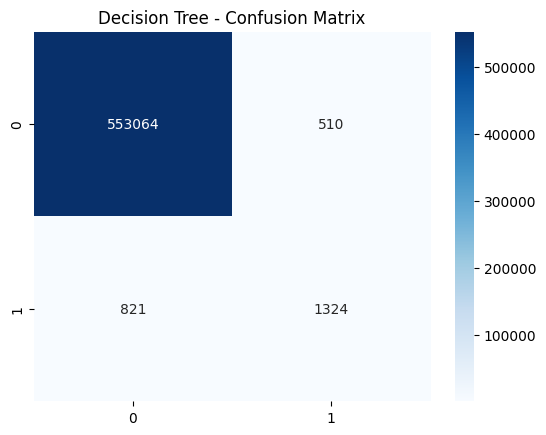

In [24]:
# Plot confusion matrix for decision tree.
sns.heatmap(confusion_matrix(y_test, y_pred_tree), annot=True, fmt='d', cmap='Blues')
plt.title("Decision Tree - Confusion Matrix")
plt.show()

##### Random Forest

In [25]:
# Train a random forest model with default parameters.
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [26]:
# Evaluate the random forest model's performance.
print(" === Random Forest === ")
print("\nRandom Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

 === Random Forest === 

Random Forest Accuracy: 0.997300794106374

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.69      0.55      0.61      2145

    accuracy                           1.00    555719
   macro avg       0.84      0.77      0.80    555719
weighted avg       1.00      1.00      1.00    555719



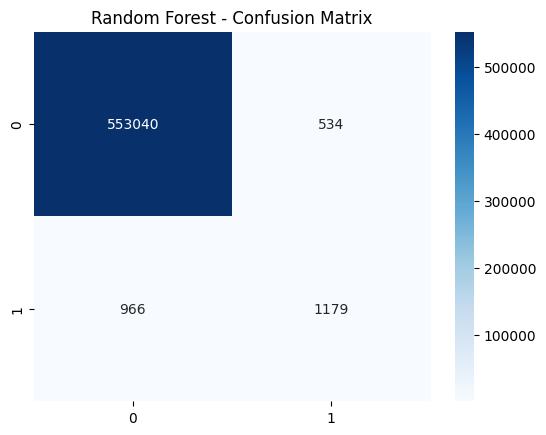

In [27]:
# Plot confusion matrix for random forest.
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.show()

### Computing and plotting ROC Curve

In [28]:
# Calculate ROC curves for all models.
fpr1, tpr1, _ = roc_curve(y_test, log_best.predict_proba(X_test)[:,1])
fpr2, tpr2, _ = roc_curve(y_test, tree_best.predict_proba(X_test)[:,1])
fpr3, tpr3, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])

C:\Users\Rutvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Rutvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


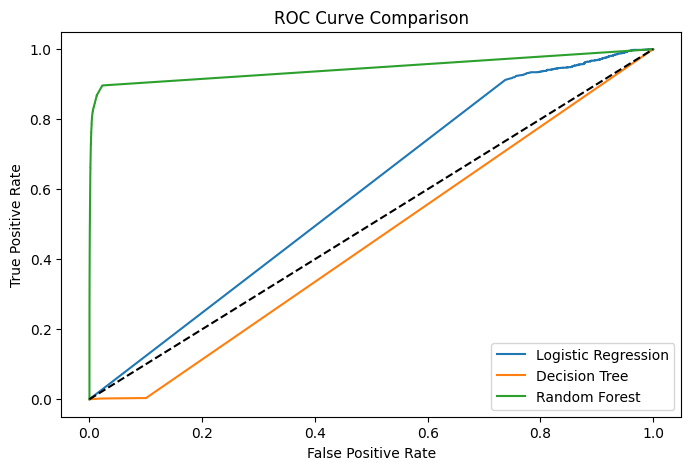

In [29]:
# Plot ROC curves for all models.
plt.figure(figsize=(8, 5))
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Decision Tree')
plt.plot(fpr3, tpr3, label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

### Defining models and performing cross validation

In [30]:
# Create a dictionary to store the models and their best parameters.
models = {
    'Logistic Regression': log_best,
    'Decision Tree': tree_best,
    'Random Forest': rf
}

In [31]:
# Perform cross-validation for each model and print the accuracy scores.
print("Cross-validation Accuracy Scores:")
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y_train, cv=5, scoring='accuracy')
    print(f"{name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

Cross-validation Accuracy Scores:
Logistic Regression: 0.9937 ± 0.0000
Decision Tree: 0.9969 ± 0.0002
Random Forest: 0.9966 ± 0.0001


### Best Model Selection

In [32]:
# Store accuracies in a dictionary for comparison.
accuracies = {
    'Logistic Regression': accuracy_score(y_test, y_pred_log),
    'Decision Tree': accuracy_score(y_test, y_pred_tree),
    'Random Forest': accuracy_score(y_test, y_pred_rf)
}

In [33]:
# Find the best model based on accuracy and print the results.
best_model_name = max(accuracies, key=accuracies.get)
print(f"\nBest Model: {best_model_name} with Accuracy = {accuracies[best_model_name]:.4f}")


Best Model: Decision Tree with Accuracy = 0.9976
